In [ ]:
'''

RESEARCH TOPIC: My Project is designed to determine the shape of the MW-M31 merger halo remnant. 
I expect the remnant to be oblate (x = y > z). In order to do this, I need to compare all 3 axial
lengths of the halo remnant. 

I need to create 2 plots of the halo: x vs. y and x vs. z, and use the package photutils 
to overplot isodensity contours onto each to get the axial lengths in x, y, and z. The package 
will tell me the axial lengths of each contour. These will be the values used for comparison. 
I need to make the graphs into images to use photutils. 

PLANNED STEPS:

1. import parackges (numpy, photutils, matplotlib,etc..) and CenterOfMass2
2. use an index to sort particles by type. I only need the halo particles for this 
project (type 1). 
3. combine the halo particle only position arrays so I can plot the combined 
MW-M31 halo. (use np.concatenate()?)
4. find center of mass using modified CenterOfMass2. This will determine the
r needed for Hernquist profile 
5. determine new combined halo mass from GalaxyMass code.
6. fit the Hernquist profile. This will determine the scale length (h_a). 
7. plot x vs. y 
8. plot x vs. z
9. convert plots to histograms/images. Photutils will only overplot on images.
10. use Photutils to overplot the isodensity contours, and get the ellipticity. 
use the scale radius to plot the guess 
11. compare. if x = y > z, then remnant is, indeed, oblate. if x = y < z, it is prolate. 

(OPTIONAL)
12. If i have time, I might overplot some contours using 1/2*h_a, or 2*r_a to compare. 


In [1]:
#import functions and classes
from ReadFile import Read
from RSCenterOfMass import CenterOfMass

#import packages
import numpy as np
import astropy.units as u
import astropy.constants as const 
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm

#import photutils packages
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture
from photutils.isophote import Ellipse

In [2]:
'''
Halodata() is an entirely new function I am building to facilitate
this project. 
'''
def Halodata(filename1,filename2):
    '''
    Halodata() is a function that will read the data from snapshot files for the 
    post-merger MW-M31 galaxy, pick out the halo particles, and create 
    arrays for the x, y, and z positions, as well as an array for the masses.

    PARAMETERS
    ----------
        filename1: 'str'
            the name of the snapshot file for the first galaxy
        filename2: 'str'
            the name of the snapshot file for the second galaxy

    OUTPUTS
    -------
        x_array: 'np.ndarray'
            an array that contains the x position of every particle in the 
            combined halo. 
        y_array: 'np.ndarray'
            an array that contains the y position of every particle in the 
            combined halo. 
        z_array: 'np.ndarray'
            an array that contains the z position of every particle in the 
            combined halo. 
        m_array: 'np.ndarray'
            an array that contains the masses of every particle in the 
            combined halo. 
    '''

    #read in both snapshot files
    time1, total_part1, data1 = Read(filename1)
    time2, total_part2, data2 = Read(filename2) 

    #create indexes to sort out the particles we want to examine by type
    #(in this case, type = 1, for halo particles.)
    index1 = np.where(data1['type'] == 1)
    index2 = np.where(data2['type'] == 1)

    #separate out the positions and mass for each halo particle for both files
    x1 = data1['x'][index1]
    y1 = data1['y'][index1]
    z1 = data1['z'][index1]
    m1 = data1['m'][index1]    

    x2 = data2['x'][index2]
    y2 = data2['y'][index2]
    z2 = data2['z'][index2]
    m2 = data2['m'][index2]

    #combine arrays using np.concatenate()
    x_array = np.concatenate((x1,x2))
    y_array = np.concatenate((y1,y2))
    z_array = np.concatenate((z1,z2))
    m_array = np.concatenate((m1,m2))
    
    #return the arrays for 
    return x_array, y_array, z_array, m_array

In [3]:
'''
find the total mass of the halo by summing over all of the values in m_array. 
halo_mass will be used later to make the Hernquist Mass Profile. 
'''

#calling Halodata() with files from appropriate M31 and MW snapshot file
x,y,z,m = Halodata("HIGHRESM31_630.txt", "HIGHRESMW_630.txt" )

#print(m) #test

#np.sum() totals the values of the array. halo_mass is a float. 
halo_mass = np.sum(m) #mass will be in 10**10 M_Sun. May need to change later. 

print(halo_mass) #test

389.5805000000002


In [4]:
#np.sum(x*m)/np.sum(m) #comparison value for CenterOfMass to test accuracy

In [5]:
'''
Need to find COM of merged galaxies to make the mass profile 

I am using an adapted version of the CenterOfMass class created in HW 5, in a file called "RSCenterOfMass"
(RS short for Research Assignment). This version of the function only includes the COM_P 
function, since I only need to find the positions. This class has been altered to
read from arrays instead of a file, due to the array outputs of Halodata(). 
'''

#make an instance of the CenterOfMass class
COM = CenterOfMass()

#call COM_P, the function that finds the center of mass position from the 
#CenterOfMass Class, error tolerance and voldec have been altered for defaults 
Remnant_COM = COM.COM_P(1,4,x,y,z,m)

print(Remnant_COM) #test

#centering halo (this will be used later to plot the distributions) 
x_cen = x - Remnant_COM[0].value
y_cen = y - Remnant_COM[1].value
z_cen = z - Remnant_COM[2].value


[121.4   75.22  91.43] kpc


In [6]:
#Compute the Hernquist Mass Profile
#Find the scale radius for the combined halo (guess and check for values of h_a)

#make array of radii (in kpc) to give to Hernquist Mass
r_bins = np.linspace(5,200,30) #test these bins for r with HernquistMass first and refine 


#CODE FROM MASS PROFILE (HOMEWORK 5)

def MassEnclosed(radius):
    ''' Method to compute the mass enclosed within a given radius
        
    PARAMETERS
    ----------
    radius -- (array) an array of radii magnitudes 
        
    RETURNS
    -------
    mass_sum -- (array) an array made up of the mass enclosed within a given radius,
    with astropy units Msun
    '''
    #determining the radius (relative to the COM) of the particle
    pradius = np.sqrt(x_cen**2 + y_cen**2 + z_cen**2) 

    #create array that will store the sum of the masses within the enclosed radius. 
    #initialize with zeros.
    #zeros_like() makes it the same size as the radius arrray. 
    mass_sum = np.zeros_like(radius)

    #looping over the given radius array. i is the index and r is the actual value of the radius
    #array at index i 
    for i, r in enumerate(radius):
        r_enc = np.where(pradius < r) #finding all the particle radii inside of the specified radius
        mass_enc = m[r_enc] #grabbing the relevant masses from the particles inside the radius
        mass_sum[i] =  np.sum(mass_enc) #adding all masses enclosed together & adding the sum to the array. 
            
    #giving elements of mass array the proper units (Solar Mass)
    mass_sum = mass_sum

    return mass_sum

#calling MassEnclosed() with the halo mass to find the mass enclosed.
Remnant_Mass = MassEnclosed(r_bins)


#Find the Hernquist Profile

def HernquistMass(r,h_a, m_halo):
    """ Function that defines the Hernquist 1990 mass profile 
        
    PARAMETERS
    ----------
    r -- (astropy quantity) Galactocentric distance in kpc 
    h_a -- (astropy quantity) scale radius of the Hernquist profile in kpc
    m_halo -- (float) total halo mass in Msun
        
    RETURNS
    -------
    M_hernquist -- (array) total mass within the input radius r in Msun
    """
    
    #M = m_halo*r**2/(a + r)**2
    
    a = m_halo #constant

    b = r**2/(h_a + r)**2
    
    M_hernquist = a * b # Hernquist Profile
    
    return M_hernquist

#call HernquistMass to get the Hernquist Mass profile
HQ_Profile = HernquistMass(r_bins, 96, halo_mass)

Text(0.5, 0, 'radius [kpc]')

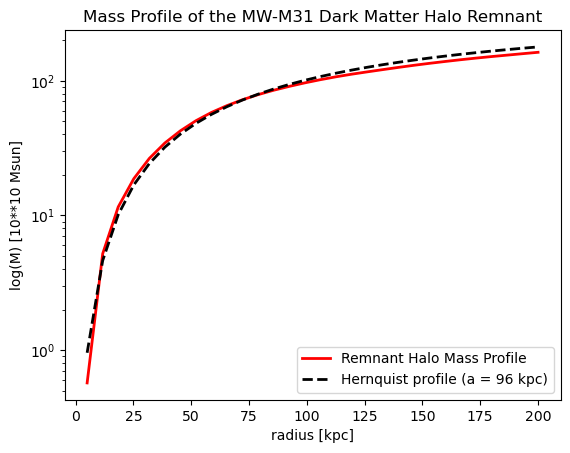

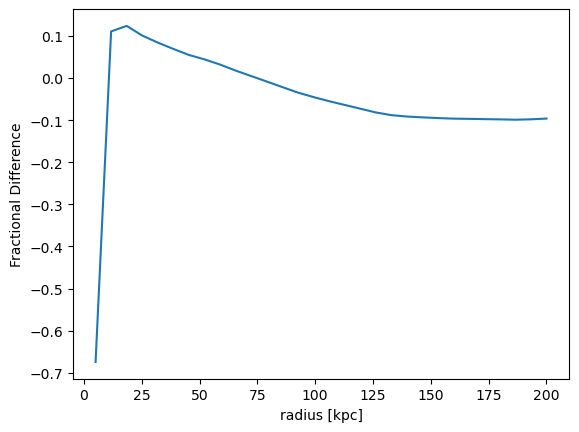

In [57]:
#plot below. 

#creating the plot 
fig,ax = plt.subplots()

#plotting y axis in log scale
ax.semilogy(r_bins, Remnant_Mass, color = "red",  label = "Remnant Halo Mass Profile", linewidth = "2",)
ax.semilogy(r_bins, HQ_Profile, color = "black", label = "Hernquist profile (a = 96 kpc)", linewidth = "2", linestyle = "--")

#making axes labels and setting the legend to show
ax.set_title ("Mass Profile of the MW-M31 Dark Matter Halo Remnant")
ax.set_ylabel("log(M) [10**10 Msun]")
ax.set_xlabel("radius [kpc]")
ax.legend()

# Save to a file
plt.savefig('HaloProfile.png')

#plot difference to check accuracy 
diff = (Remnant_Mass - HQ_Profile)/Remnant_Mass

fig,ax = plt.subplots()
ax.plot(r_bins, diff)
ax.set_ylabel("Fractional Difference")
ax.set_xlabel("radius [kpc]")

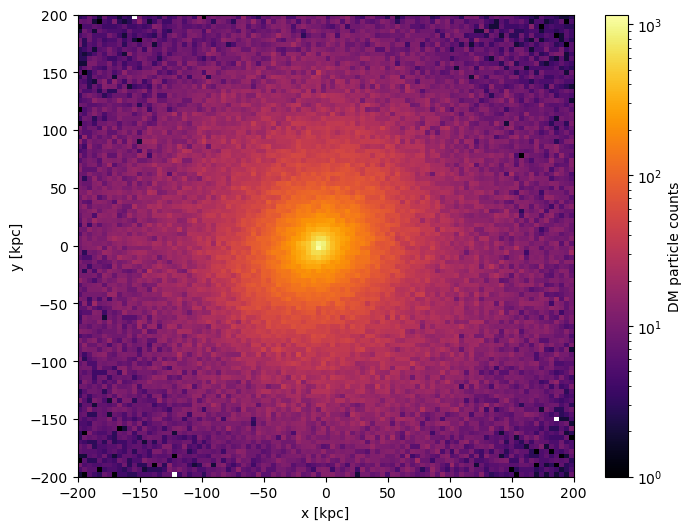

In [17]:
'''
note for tuesday 3/22:

***look at lab 7 

make 2D histogram of particles with scale radius (h_a = 60) circle overplotted to show its eccentricity (for now)

FOLLOWING TUTORIAL BY HIMANSH
'''

#x vs y projection

fig = plt.figure(figsize = (8, 6))
ax0 = fig.add_subplot(1, 1, 1)
_, _, _, plot = plt.hist2d(x_cen, y_cen, range = ((-200, 200), (-200, 200)), bins = 100, norm = LogNorm(), cmap = plt.cm.inferno)
fig.colorbar(plot, ax = ax0, label = 'DM particle counts')
ax0.set_xlabel('x [kpc]')
ax0.set_ylabel('y [kpc]')
plt.show()


/var/folders/v1/c5bw5tvn0fx16gl6x3gs4n3m0000gn/T/ipykernel_93467/933507465.py:31: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.log10(counts1).T, cmap = cm, origin = "lower") #imshow transposes the matrix, so transposing again to reverse


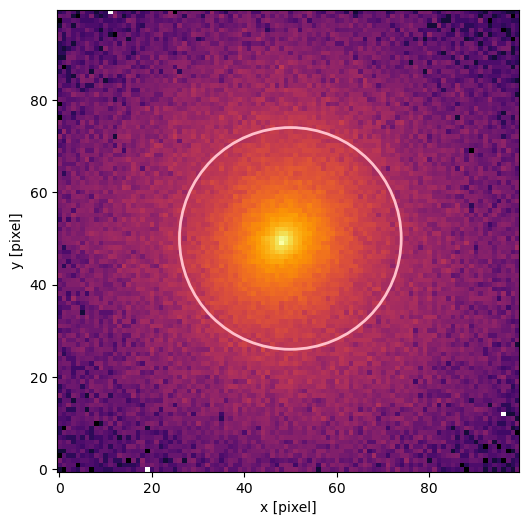

In [35]:
'''
fitting ellipses using the tutorial by himansh
'''

#Initializing the ellipse

counts1, xedges1, yedges1 = np.histogram2d(x_cen, y_cen, bins = 100, range = ((-200, 200), (-200, 200)))
#our bin size is:
x_binsize1 = xedges1[1] - xedges1[0]
y_binsize1 = yedges1[1] - yedges1[0]

#converting the center into pixel units
x_cen_pixel1 = -xedges1[0]/x_binsize1
y_cen_pixel1 = -yedges1[0]/y_binsize1

#defining the ellipse geometry
geometry1 = EllipseGeometry(x0 = x_cen_pixel1, y0 = y_cen_pixel1, sma = 96/x_binsize1, eps = 0, pa = 0)
#sma is the semi-major axis, eps is the ellipticity and pa is the position angle
#constructing the ellipse
'''
CHIP NOTE: using scale radius to fit the guess ( = 96)
'''
aper1 = EllipticalAperture((geometry1.x0, geometry1.y0), geometry1.sma, geometry1.sma * (1 - geometry1.eps), 
                           geometry1.pa) 

#Plotting the guess 

fig = plt.figure(figsize = (6, 6))
ax0 = fig.add_subplot(1, 1, 1)
cm = plt.cm.inferno
im = plt.imshow(np.log10(counts1).T, cmap = cm, origin = "lower") #imshow transposes the matrix, so transposing again to reverse
ax0.set_xlabel('x [pixel]')
ax0.set_ylabel('y [pixel]')
aper1.plot(color = 'pink', linewidth = 2)
plt.show()

In [37]:
#Performing the fit 

ellipse1 = Ellipse(counts1.T, geometry1) #initializing the ellipse object
#you need to transpose the counts matrix to reverse the effect of transposition that Ellipse does internally
isolist1 = ellipse1.fit_image() 

/var/folders/v1/c5bw5tvn0fx16gl6x3gs4n3m0000gn/T/ipykernel_93467/3098593253.py:6: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.log10(counts1).T, cmap = cm, origin = "lower")


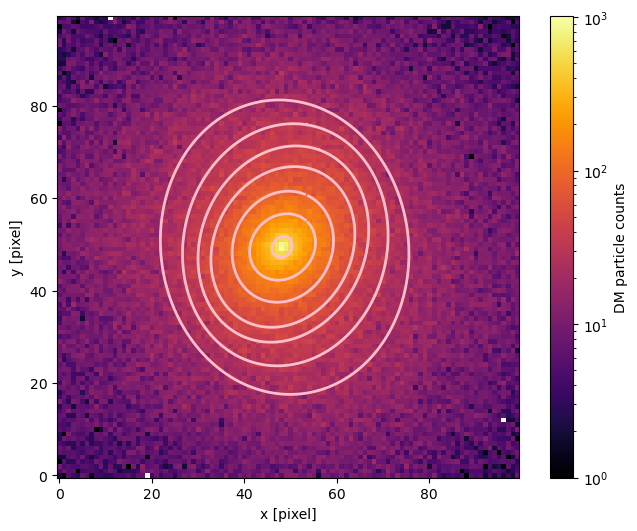

In [47]:
#plotting ellipses

fig = plt.figure(figsize = (8, 6))
ax0 = fig.add_subplot(1, 1, 1)
cm = plt.cm.inferno
im = plt.imshow(np.log10(counts1).T, cmap = cm, origin = "lower")
fig.colorbar(plot, ax = ax0, label = 'DM particle counts')
ax0.set_xlabel('x [pixel]')
ax0.set_ylabel('y [pixel]')

#defining the semi-major axes in pixel coordinates
sma_min = 10/x_binsize1
sma_max = 150/x_binsize1
separation = 20/x_binsize1
sma_array = np.arange(sma_min, sma_max, separation) #each contour will be separated by 20 kpc

for my_sma in sma_array:
    iso1 = isolist1.get_closest(my_sma)
    #the get_closest method obtains the elliptical contour whose semi-major axis is closest to what you want
    x, y = iso1.sampled_coordinates()
    ax0.plot(x, y, color = 'pink', linewidth = 2)

plt.savefig('XYprojection')

plt.show()

In [43]:
'''
Reading data from photutils. 
need to read: eccentricity (e = 1 - b/a where b = semi-minor axis and a = semi-major axis)
'''

sma_kpc = 96 #required semi-major axis in kpc
sma_pixel1 = 96/x_binsize1 #required semi-major axis in pixel units

#obtain the elliptical contour whose semi-major axis is closest to 100 kpc
iso1_96 = isolist1.get_closest(sma_pixel1)

#reading the ellipticity
eps1_96 = iso1_96.eps
print("Ellipticity of 96 kpc elliptical contour: ", eps1_96)

Ellipticity of 96 kpc elliptical contour:  0.15490809866925553


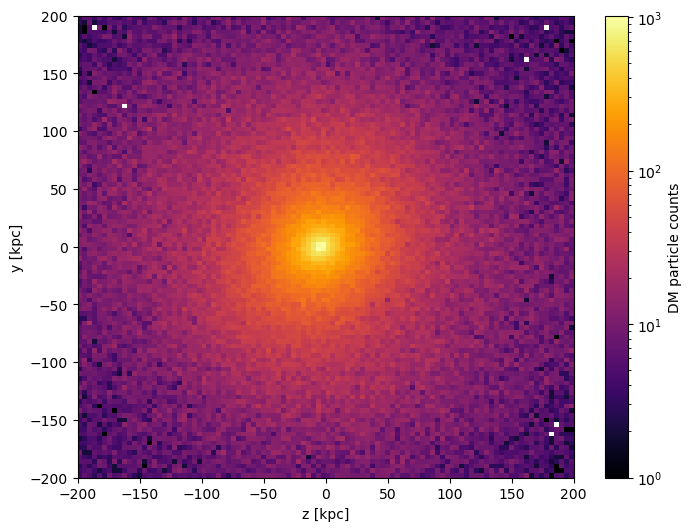

In [13]:
#Z VS Y PROJECTION

fig = plt.figure(figsize = (8, 6))
ax0 = fig.add_subplot(1, 1, 1)
_, _, _, plot = plt.hist2d(z_cen, y_cen, range = ((-200, 200), (-200, 200)), bins = 100, norm = LogNorm(), cmap = plt.cm.inferno)
fig.colorbar(plot, ax = ax0, label = 'DM particle counts')
ax0.set_xlabel('z [kpc]')
ax0.set_ylabel('y [kpc]')
plt.show()


/var/folders/v1/c5bw5tvn0fx16gl6x3gs4n3m0000gn/T/ipykernel_93467/528187739.py:27: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.log10(counts3).T, cmap = cm, origin = "lower") #imshow transposes the matrix, so transposing again to reverse


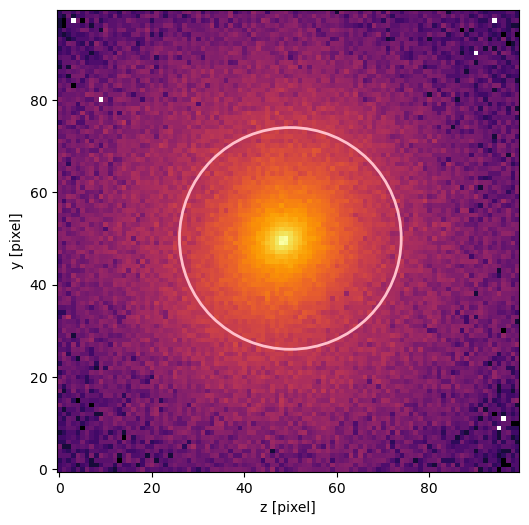

In [49]:
#Initializing the ellipse

counts3, zedges3, yedges3 = np.histogram2d(z_cen, y_cen, bins = 100, range = ((-200, 200), (-200, 200)))
#our bin size is:
z_binsize3 = zedges3[1] - zedges3[0]
y_binsize3 = yedges3[1] - yedges3[0]

#converting the center into pixel units
z_cen_pixel3 = -zedges3[0]/z_binsize3
y_cen_pixel3 = -yedges3[0]/y_binsize3

#defining the ellipse geometry
geometry3 = EllipseGeometry(x0 = z_cen_pixel3, y0 = y_cen_pixel3, sma = 96/z_binsize3, eps = 0, pa = 0)
#sma is the semi-major axis, eps is the ellipticity and pa is the position angle
#constructing the ellipse
'''
CHIP NOTE: using scale radius to fit the guess (a = 96 kpc)
'''
aper3 = EllipticalAperture((geometry3.x0, geometry3.y0), geometry3.sma, geometry3.sma * (1 - geometry3.eps), 
                           geometry3.pa) 

#Plotting the guess 

fig = plt.figure(figsize = (6, 6))
ax0 = fig.add_subplot(1, 1, 1)
cm = plt.cm.inferno
im = plt.imshow(np.log10(counts3).T, cmap = cm, origin = "lower") #imshow transposes the matrix, so transposing again to reverse
ax0.set_xlabel('z [pixel]')
ax0.set_ylabel('y [pixel]')
aper3.plot(color = 'pink', linewidth = 2)
plt.show()

In [51]:
#Performing the fit 

ellipse3 = Ellipse(counts3.T, geometry3) #initializing the ellipse object
#you need to transpose the counts matrix to reverse the effect of transposition that Ellipse does internally
isolist3 = ellipse3.fit_image() 

/var/folders/v1/c5bw5tvn0fx16gl6x3gs4n3m0000gn/T/ipykernel_93467/666773696.py:6: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.log10(counts3).T, cmap = cm, origin = "lower")


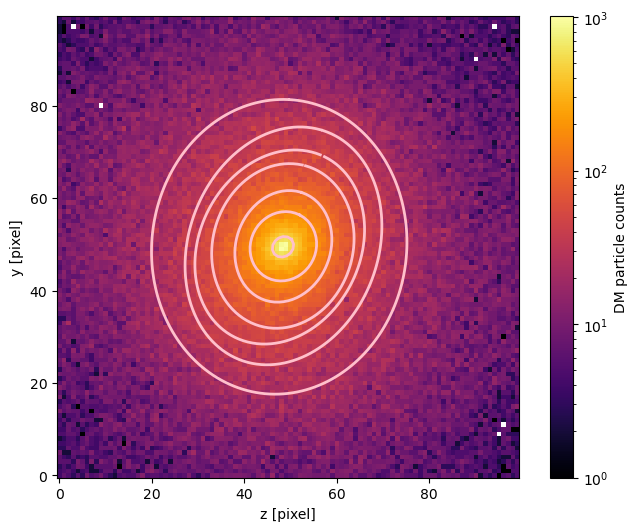

In [52]:
#plotting ellipses

fig = plt.figure(figsize = (8, 6))
ax0 = fig.add_subplot(1, 1, 1)
cm = plt.cm.inferno
im = plt.imshow(np.log10(counts3).T, cmap = cm, origin = "lower")
fig.colorbar(plot, ax = ax0, label = 'DM particle counts')
ax0.set_xlabel('z [pixel]')
ax0.set_ylabel('y [pixel]')

#defining the semi-major axes in pixel coordinates
sma_min = 10/z_binsize3
sma_max = 150/z_binsize3
separation = 20/z_binsize3
sma_array = np.arange(sma_min, sma_max, separation) #each contour will be separated by 20 kpc

for my_sma in sma_array:
    iso3 = isolist3.get_closest(my_sma)
    #the get_closest method obtains the elliptical contour whose semi-major axis is closest to what you want
    z, y = iso3.sampled_coordinates()
    ax0.plot(z, y, color = 'pink', linewidth = 2)

plt.savefig('ZYprojection.png')

plt.show()

In [55]:
'''
Reading data from photutils. 
need to read: ellipticity (e = 1 - b/a where b = semi-minor axis and a = semi-major axis)
'''

sma_kpc = 96 #required semi-major axis in kpc
sma_pixel = 96/z_binsize3 #required semi-major axis in pixel units

#obtain the elliptical contour whose semi-major axis is closest to 100 kpc
iso3_96 = isolist3.get_closest(sma_pixel)

#reading the ellipticity
eps3_96 = iso3_96.eps
print("Ellipticity of 96 kpc elliptical contour: ", eps3_96)

Ellipticity of 96 kpc elliptical contour:  0.1984112848750076


In [73]:
'''
DETERMINING THE TRIAXIALITY PARAMETER: T = (1-q^2)/(1-s^2)
x vs y gives b/a (q), and z vs y gives b/c

therefore s = c/a = b/a * c/b

e = 1 - b/a therefore b/a = 1 - e
'''

#determine q (b/a)
q = 1 - eps1_96
print("q is:",q) #seems appropriate

#determine b/c from z v s y graph 
bc = 1 - eps3_96
print("b/c is:",bc) #seems appropriate

#determine s (c/a = b/a * 1/(b/c))
s = q * 1/(bc)
print("s is", s) #s is greater than 1? That doesn't seem right. 

#determine triaxiality T 
T = (1-q**2)/(1-s**2)
print("the triaxiality of the halo is",T) #not correct for sure. T should be between 0 and 1. 

q is: 0.8450919013307445
b/c is: 0.8015887151249924
s is 1.0542712059001087
the triaxility of the halo is -2.5636862588067113
